# Python: Panel Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.did import DoubleMLDIDMulti
from doubleml.data import DoubleMLPanelData

from doubleml.did.datasets import make_did_CS2021

# simulate data
n_obs = 5000
df = make_did_CS2021(n_obs, dgp_type=1, n_periods=8, n_pre_treat_periods=4, time_type="datetime")
df["ite"] = df["y1"] - df["y0"]

In [2]:
# rename for plotting
df["First Treated"] = df["d"].dt.strftime("%Y-%m").fillna("Never Treated")
df.head()

,id,y,y0,y1,d,t,Z1,Z2,Z3,Z4,ite,First Treated
0,0,196.628345,196.628345,196.469772,2025-07-01,2025-01-01,-1.378363,-1.563339,-1.755421,-1.267233,-0.158573,2025-07
1,0,184.014741,184.014741,184.639146,2025-07-01,2025-02-01,-1.378363,-1.563339,-1.755421,-1.267233,0.624406,2025-07
2,0,171.033521,171.033521,173.094369,2025-07-01,2025-03-01,-1.378363,-1.563339,-1.755421,-1.267233,2.060849,2025-07
3,0,160.310762,160.310762,160.414796,2025-07-01,2025-04-01,-1.378363,-1.563339,-1.755421,-1.267233,0.104035,2025-07
4,0,150.447513,150.447513,151.102154,2025-07-01,2025-05-01,-1.378363,-1.563339,-1.755421,-1.267233,0.654641,2025-07


In [3]:

# Create aggregation dictionary for means
def agg_dict(col_name):
    return {
        f'{col_name}_mean': (col_name, 'mean'),
        f'{col_name}_lower_quantile': (col_name, lambda x: x.quantile(0.05)),
        f'{col_name}_upper_quantile': (col_name, lambda x: x.quantile(0.95))
    }

# Calculate means and confidence intervals
agg_dictionary = agg_dict("y") | agg_dict("ite")
# convert "d" to month period

# fill NaT values since they are not supported by groupby
agg_df = df.groupby(["t", "First Treated"]).agg(**agg_dictionary).reset_index()
agg_df.head()

,t,First Treated,y_mean,y_lower_quantile,y_upper_quantile,ite_mean,ite_lower_quantile,ite_upper_quantile
0,2025-01-01,2025-05,209.232972,202.011675,216.526857,0.054854,-2.278644,2.420543
1,2025-01-01,2025-06,210.451564,203.071081,218.424421,-0.073761,-2.409091,2.299715
2,2025-01-01,2025-07,211.487736,204.039630,219.377341,0.000180,-2.362993,2.340590
3,2025-01-01,2025-08,213.457445,204.544638,222.339047,-0.054813,-2.368209,2.522341
4,2025-01-01,Never Treated,215.221319,206.282226,225.772989,0.008458,-2.368282,2.319752


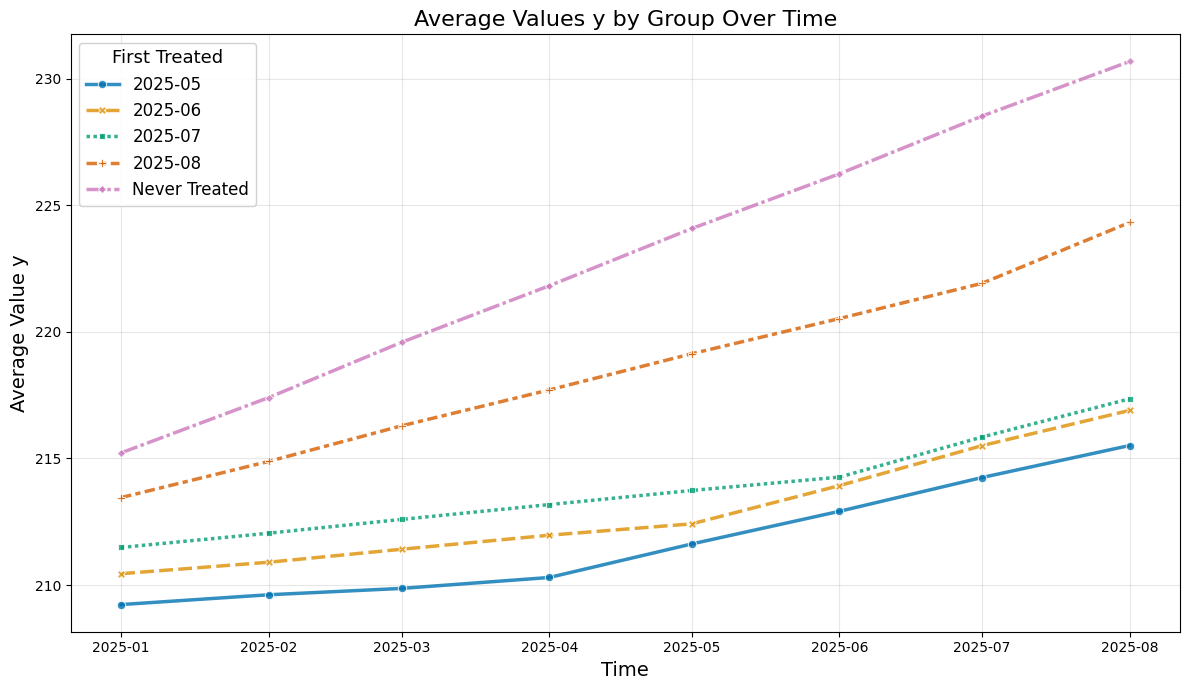

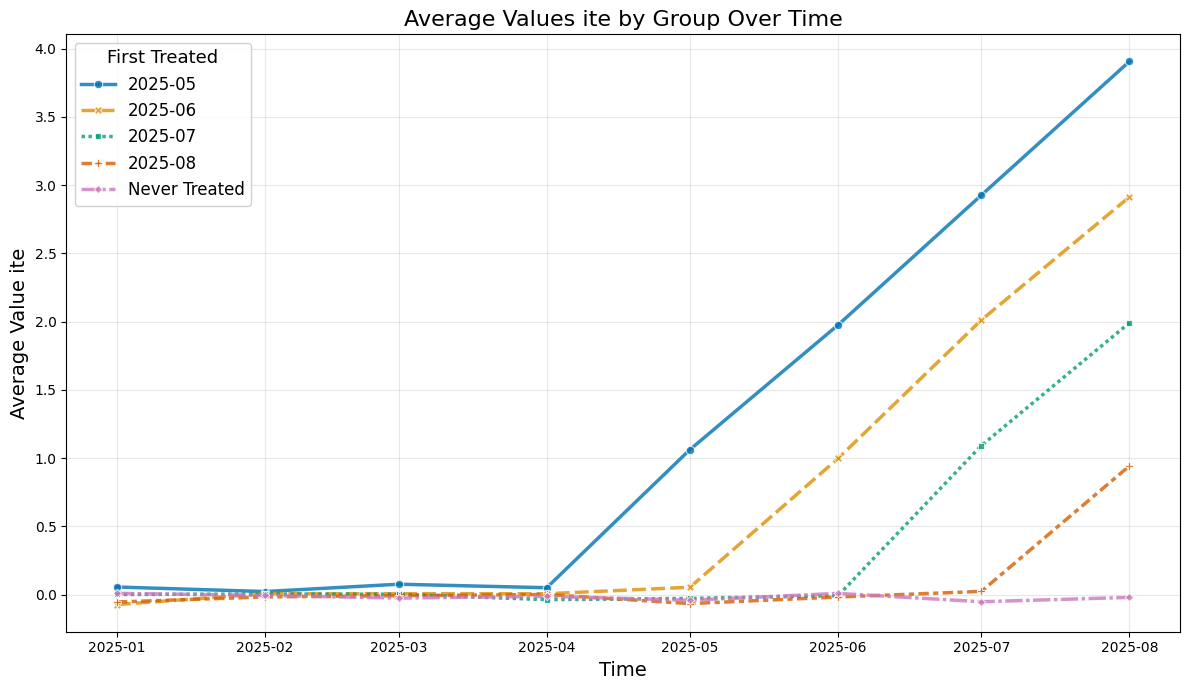

In [4]:
def plot_data_seaborn_improved(df, col_name='y'):
    """
    Create an improved plot with colorblind-friendly features
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    col_name : str, default='y'
        Column name to plot (will use '{col_name}_mean')
    """
    plt.figure(figsize=(12, 7))
    n_colors = df["First Treated"].nunique()
    color_palette = sns.color_palette("colorblind", n_colors=n_colors)

    sns.lineplot(
        data=df,
        x='t',
        y=f'{col_name}_mean',
        hue='First Treated',
        style='First Treated',
        palette=color_palette,
        markers=True,
        dashes=True,
        linewidth=2.5,
        alpha=0.8
    )
    
    plt.title(f'Average Values {col_name} by Group Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'Average Value {col_name}', fontsize=14)
    

    plt.legend(title='First Treated', title_fontsize=13, fontsize=12, 
               frameon=True, framealpha=0.9, loc='best')
    
    plt.grid(alpha=0.3, linestyle='-')
    plt.tight_layout()

    plt.show()

# Call the function with your dataframes
plot_data_seaborn_improved(agg_df)
plot_data_seaborn_improved(agg_df, col_name='ite')

In [5]:
dml_data = DoubleMLPanelData(df, y_col="y", d_cols="d", id_col="id", t_col="t", x_cols=["Z1", "Z2", "Z3", "Z4"], datetime_unit="M")
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 12 entries, id to First Treated
dtypes: datetime64[s](2), float64(8), int64(1), object(1)
memory usage: 3.7+ MB



In [6]:
# control_group = "not_yet_treated"
control_group = "never_treated"

gt_combinations = "all"
#gt_combinations = "standard"

ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

ml_g = LinearRegression()
ml_m = LogisticRegression()

dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=ml_g,
    ml_m=ml_m,
    gt_combinations=gt_combinations,
    control_group=control_group,
)

dml_obj.fit()
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.40636468 1.44015593 1.42710964 1.42719583 1.43995196 1.4435586
  1.39726542 1.42461424 1.43808497 1.44409564 1.40017327 1.39597072
  1.396656   1.43945749 1.40855224 1.37310968 1.4149736  1.40179805
  1.40867837 1.39912807 1.42085823 1.41535716 1.40426326 1.43647614
  1.43173649 1.42466185 1.43807652 1.44161035 1.39454981 1.42545671
  1.44018884 1.44159814 1.39295159 1.3933023  1

(<Figure size 1200x800 with 5 Axes>,
 [<Axes: title={'center': 'First Treated: 2025-05'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-06'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-07'}, ylabel='Effect'>,
  <Axes: title={'center': 'First Treated: 2025-08'}, xlabel='Evaluation Period', ylabel='Effect'>])

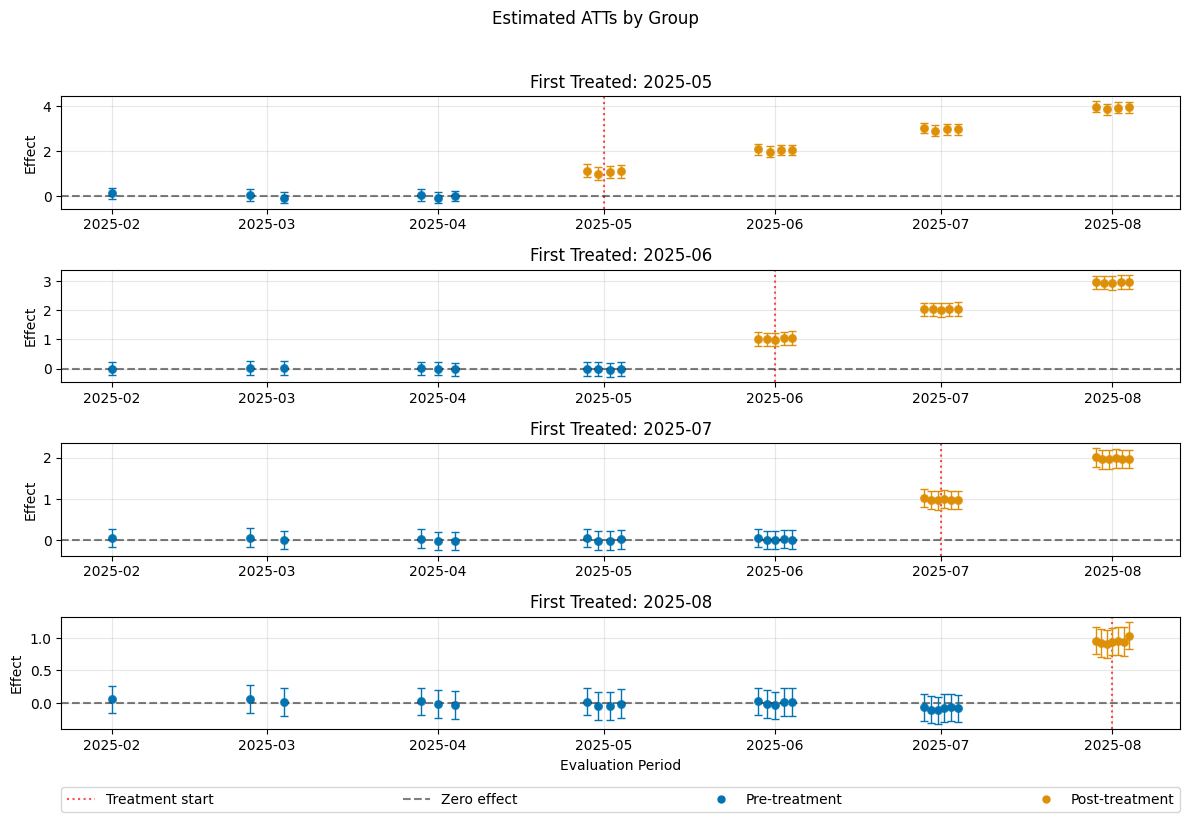

In [7]:
dml_obj.bootstrap()
dml_obj.plot_effects(default_jitter=0.1)

In [8]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
                              CI lower  theta lower     theta  theta upper  \
ATT(2025-05,2025-01,2025-02) -0.089584     0.030287  0.119351     0.208415   
ATT(2025-05,2025-01,2025-03) -0.187237    -0.056760  0.036582     0.129924   
ATT(2025-05,2025-02,2025-03) -0.290854    -0.167463 -0.077922     0.011618   
ATT(2025-05,2025-01,2025-04) -0.175551    -0.046868  0.046674     0.140216   
ATT(2025-05,2025-02,2025-04) -0.305745    -0.178785 -0.083015     0.012755   
...                                ...          ...       ...          ...   
ATT(2025-08,2025-03,2025-08)  0.713646     0.819071  0.905554     0.992036   
ATT(2025-08,2025-04,2025-08)  0.752304     0.857735  0.944158     1.030581   
ATT(2025-08,2025-05,2025-08)  0.763137  

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.743996 0.027255 63.987523    0.0 1.690577 1.797416
------------------ Aggregated Effects         ------------------
             coef   std err          t  P>|t|     2.5 %    97.5 %
2025-05  2.504777  0.038855  64.465171    0.0  2.428623  2.580931
2025-06  1.996162  0.034710  57.509321    0.0  1.928131  2.064193
2025-07  1.473812  0.038550  38.230791    0.0  1.398255  1.549370
2025-08  0.952538  0.048625  19.589422    0.0  0.857235  1.047842
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



/home/ubuntu/.venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Aggregated Treatment Effects'}, ylabel='Effect'>)

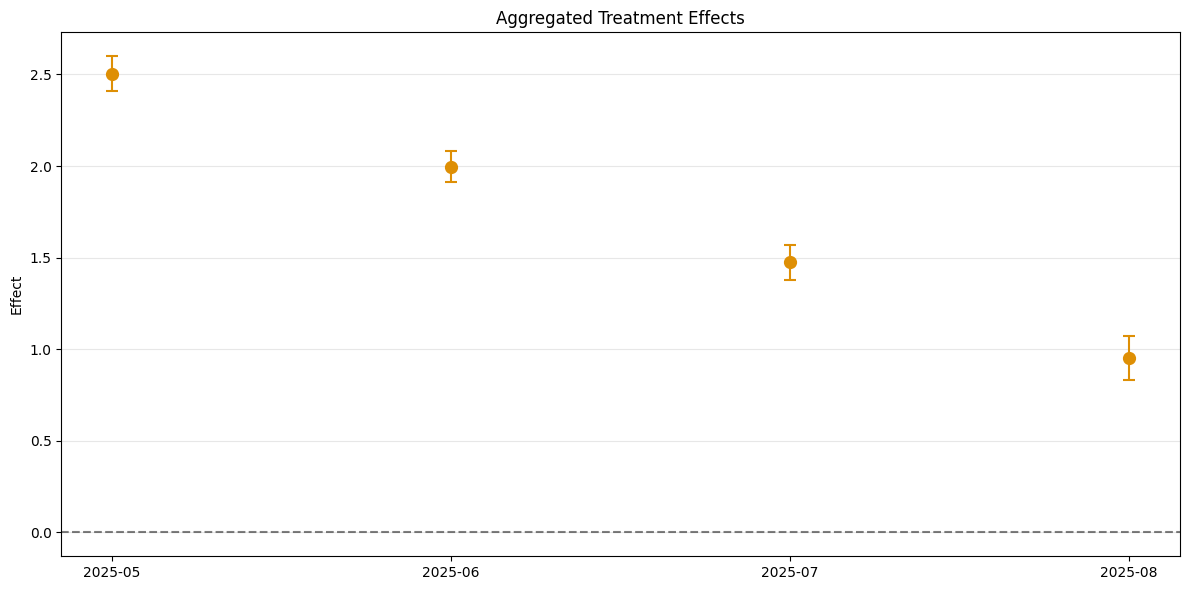

In [9]:
aggregated = dml_obj.aggregate("group")
print(aggregated)
aggregated.plot_effects()

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %  97.5 %
2.474609 0.031322 79.004292    0.0 2.413218   2.536
------------------ Aggregated Effects         ------------------
               coef   std err          t     P>|t|     2.5 %    97.5 %
-6 months  0.050784  0.063342   0.801737  0.422705 -0.073365  0.174932
-5 months  0.041111  0.043754   0.939584  0.347431 -0.044646  0.126868
-4 months  0.002663  0.035115   0.075850  0.939538 -0.066160  0.071487
-3 months  0.005673  0.030395   0.186639  0.851944 -0.053900  0.065246
-2 months -0.002458  0.027898  -0.088089  0.929806 -0.057137  0.052222
-1 months -0.032274  0.026593  -1.213649  0.224882 -0.084395  0.019847
0 months   0.996740  0.026678  37.361703  0.000000  0.944452  1.049028
1 months   2.006814  0.031848  63.011564  0.000000  1.944393  2.069236
2 months   2.959074  0.040557  7

/home/ubuntu/.venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Aggregated Treatment Effects'}, ylabel='Effect'>)

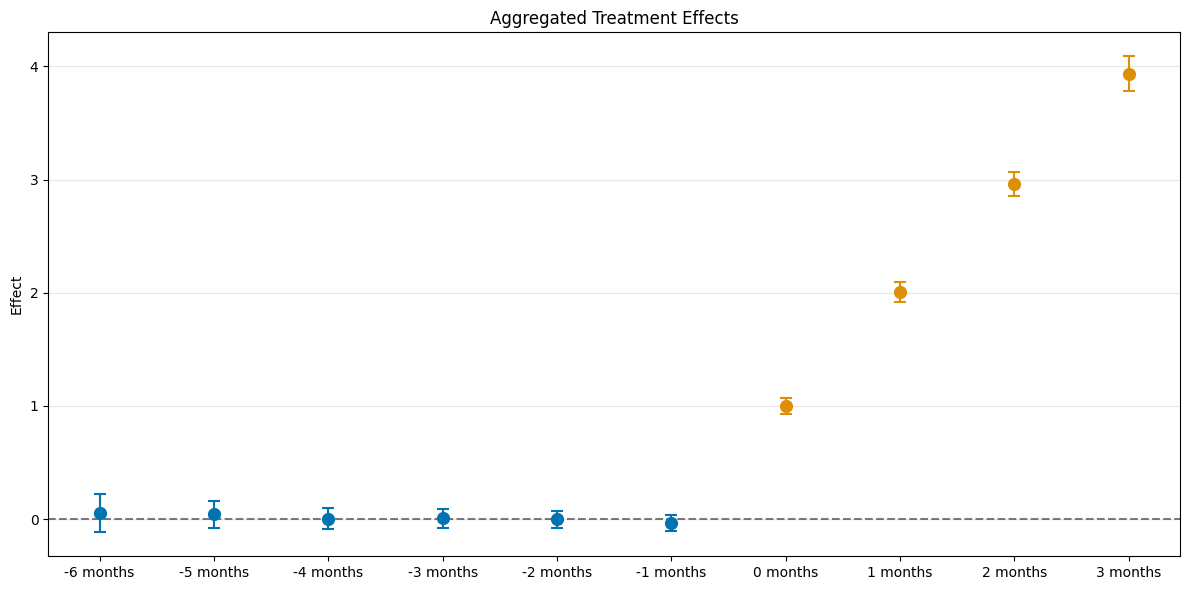

In [10]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)
aggregated_eventstudy.plot_effects()